# Class Files

In [2]:
from classes import Layer, Linear, Sequential, Sigmoid, Tanh, ReLU, BinaryCrossEntropyLoss



# NYC Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import pandas as pd
import seaborn as sns
import plotly.express as px
import os

from sklearn.model_selection import train_test_split 

import warnings
warnings.filterwarnings('ignore')



## Load Dataset

In [3]:

dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()

X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]


print(X_train.shape)
print(y_train.shape)

print('-----')
print(X_test.shape)
print(y_test.shape)

(1312779, 10)
(1312779,)
-----
(145865, 10)
(145865,)


## Cleaning train dataset

In [4]:
X_train_pd = pd.DataFrame(X_train)
X_train_pd.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object

In [5]:
y_train_pd = pd.DataFrame(y_train)

y_train_pd.dtypes

trip_duration    int64
dtype: object

### Concatenate x-train & y-train

In [6]:
x_new_pd = pd.concat([X_train_pd,y_train_pd],axis =1)

x_new_pd.head()

x_new_pd.shape

x_new_pd.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
879655,id2425795,1,2016-01-08 23:55:11,2016-01-09 00:04:32,1,-73.955551,40.773346,-73.973640,40.763500,N,561
646838,id0767831,2,2016-03-05 09:52:06,2016-03-05 10:00:12,1,-73.962181,40.763599,-73.980377,40.764919,N,486
1138713,id0449104,1,2016-04-09 16:03:53,2016-04-09 16:21:22,1,-73.977486,40.751842,-74.011688,40.718925,N,1049
864716,id3030157,1,2016-01-06 11:12:44,2016-01-06 11:19:49,1,-73.970001,40.762363,-73.963264,40.774666,N,425
434927,id1584885,1,2016-06-26 09:10:56,2016-06-26 09:17:44,1,-73.950348,40.771561,-73.968178,40.762409,N,408


### Check for null

In [7]:
x_new_pd.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Preprocessing functions

In [8]:
def time_of_day(x):
    if x in range(6,12): return 'Morning'
    elif x in range(12, 16): return 'Afternoon'
    elif x in range(16,22): return 'Evening'
    else: return 'Night'
    
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the haversine distance between two points on the earth.
    
    Parameters:
    lat1, lon1: float. Latitude and longitude of the first point.
    lat2, lon2: float. Latitude and longitude of the second point.
    
    Returns:
    float. Distance in kilometers.
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = 6371 * c  # Earth's radius in kilometers
    return distance


In [9]:
def pre_process_features(df):
    
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
    
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
    
    df['pickup_timeofday']=df['pickup_hour'].apply(time_of_day)
    df['dropoff_timeofday']=df['dropoff_hour'].apply(time_of_day)
    

    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['dropoff_day'] = df['dropoff_datetime'].dt.day
    
    
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['dropoff_month'] = df['dropoff_datetime'].dt.month
    
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['dropoff_weekday'] = df['dropoff_datetime'].dt.weekday
    
    df['calc_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds()

    df['trip_distance'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )

    return df


### Pre-process train set

In [10]:
preprop_X = pre_process_features(x_new_pd)
pd.set_option('display.max_columns', None)
preprop_X.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,dropoff_hour,pickup_timeofday,dropoff_timeofday,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,calc_trip_duration,trip_distance
879655,id2425795,1,2016-01-08 23:55:11,2016-01-09 00:04:32,1,-73.955551,40.773346,-73.973640,40.763500,N,561,23,0,Night,Night,8,9,1,1,4,5,561.0,1.875964
646838,id0767831,2,2016-03-05 09:52:06,2016-03-05 10:00:12,1,-73.962181,40.763599,-73.980377,40.764919,N,486,9,10,Morning,Morning,5,5,3,3,5,5,486.0,1.539475
1138713,id0449104,1,2016-04-09 16:03:53,2016-04-09 16:21:22,1,-73.977486,40.751842,-74.011688,40.718925,N,1049,16,16,Evening,Evening,9,9,4,4,5,5,1049.0,4.658508
864716,id3030157,1,2016-01-06 11:12:44,2016-01-06 11:19:49,1,-73.970001,40.762363,-73.963264,40.774666,N,425,11,11,Morning,Morning,6,6,1,1,2,2,425.0,1.480942
434927,id1584885,1,2016-06-26 09:10:56,2016-06-26 09:17:44,1,-73.950348,40.771561,-73.968178,40.762409,N,408,9,9,Morning,Morning,26,26,6,6,6,6,408.0,1.813886


In [11]:
X_train_df = preprop_X.copy()
X_train_df.shape

(1312779, 23)

## Exploring Train Set

### Passenger Count


In [12]:

X_train_df['passenger_count'].value_counts()

passenger_count
1    930408
2    189203
5     70257
3     53849
6     43467
4     25536
0        54
7         3
8         1
9         1
Name: count, dtype: int64

In [13]:
# Remove outliers

X_train_df = X_train_df[(X_train_df['passenger_count'] != 0) & (X_train_df['passenger_count'] <= 6)]

X_train_df['passenger_count'].value_counts()

passenger_count
1    930408
2    189203
5     70257
3     53849
6     43467
4     25536
Name: count, dtype: int64

#### Plot Passenger Count Distribution

In [83]:
passenger_counts = X_train_df['passenger_count'].value_counts().reset_index()
passenger_counts.columns = ['passenger_count', 'count']

# Ensure passenger_count is treated as a numeric column and sort
passenger_counts['passenger_count'] = passenger_counts['passenger_count'].astype(int)
passenger_counts = passenger_counts.sort_values('passenger_count')

# Plot using Plotly
fig = px.bar(passenger_counts, 
             x='passenger_count', 
             y='count', 
             title='Passenger Count Distribution (Ordered by Count)',
             labels={'passenger_count': 'Passenger Count', 'count': 'Frequency'})

# Show plot
#fig.show()


### Vendor ID

In [15]:
X_train_df['vendor_id'].value_counts()

vendor_id
2    702145
1    610575
Name: count, dtype: int64


#### Plot Vendor Distribution

In [85]:
fig = px.histogram(X_train_df, 
                   x='vendor_id', 
                   title='Vendor Distribution', 
                   labels={'vendor_id': 'Venor Id'},
                   color='vendor_id',) 

# Show plot
#fig.show()

### Trip Distance

In [17]:
X_train_df = X_train_df[X_train_df['trip_distance'] != X_train_df['trip_distance'].min()]


In [18]:
X_train_df['trip_distance'].max()

1240.9086766508526

#### Removing outliers

In [19]:
# Calculate the first (Q1) and third quartile (Q3) of 'trip_distance'
Q1 = X_train_df['trip_distance'].quantile(0.25)
Q3 = X_train_df['trip_distance'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(lower_bound)
print(upper_bound)

# Count the number of data points greater than upper_bound
greater_than_upper = X_train_df[X_train_df['trip_distance'] > upper_bound].shape[0]

# Count the number of data points lower than lower_bound
lower_than_lower = X_train_df[X_train_df['trip_distance'] < lower_bound].shape[0]

# Print the results
print(f"Number of data points greater than the upper bound: {greater_than_upper}")
print(f"Number of data points lower than the lower bound: {lower_than_lower}")



-2.73121482143264
7.859662719071586
Number of data points greater than the upper bound: 126278
Number of data points lower than the lower bound: 0


In [20]:
#Removing outliers for trip distance
X_train_df = X_train_df[(X_train_df['trip_distance'] >= lower_bound) & (X_train_df['trip_distance'] <= upper_bound)]

print(X_train_df.shape)

(1181170, 23)


#### Plotting Trip Distance

In [ ]:

# Set seaborn style
sns.set_style("darkgrid")

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_train_df, x="trip_distance", y="trip_duration", alpha=0.5)

# Labels and title
plt.xlabel("Trip Distance (km)")
plt.ylabel("Trip Duration (seconds)")
plt.title("Trip Duration vs. Distance")


#plt.show()


### Trip Duration

In [22]:
X_train_df['trip_duration'].value_counts()

trip_duration
368      1445
399      1428
408      1425
369      1421
449      1419
         ... 
84403       1
84910       1
4250        1
83296       1
9197        1
Name: count, Length: 5077, dtype: int64

In [23]:

max_trip_hr = X_train_df['trip_duration'].max() / 3600

print("Max: ", max_trip_hr)

Max:  618.7811111111112


In [24]:
X_train_df['trip_duration'].sort_values(ascending= False)

924150     2227612
680594     2049578
73816        86390
59891        86387
1221666      86378
            ...   
1439166          1
1360664          1
533799           1
269418           1
35196            1
Name: trip_duration, Length: 1181170, dtype: int64

#### Removing outliers

In [25]:
X_train_df= X_train_df[X_train_df.trip_duration <= 5000]
X_train_df = X_train_df[X_train_df.trip_duration >= 60]

In [26]:
X_train_df['trip_duration'].value_counts()

trip_duration
368     1445
399     1428
408     1425
369     1421
449     1419
        ... 
3028       1
4250       1
4040       1
3087       1
3814       1
Name: count, Length: 3813, dtype: int64

### Pickup Time of Day

In [ ]:
fig = px.histogram(X_train_df, 
                   x='pickup_timeofday', 
                   title='Pickup Time of Day', 
                   labels={'pickup_timeofday': 'Time of Day'},
                   color='pickup_timeofday',  # Color by parts of the day
                   category_orders={'pickup_timeofday': ['Morning', 'Afternoon', 'Evening', 'Night']})  # Order parts of the day

# Show plot
#fig.show()

### Drop-off Time of Day

In [ ]:
fig = px.histogram(X_train_df, 
                   x='dropoff_timeofday', 
                   title='Drof-off Time of Day', 
                   labels={'dropoff_timeofday': 'Time of Day'},
                   color='dropoff_timeofday',  # Color by parts of the day
                   category_orders={'dropoff_timeofday': ['Morning', 'Afternoon', 'Evening', 'Night']})  # Order parts of the day

# Show plot
#fig.show()

### Pick-up Hours

In [ ]:
fig = px.histogram(X_train_df, 
                   x='pickup_hour', 
                   title='Pickup Hours', 
                   labels={'pickup_hour': 'Hour of Day'},
                   color='pickup_hour',  # Color by parts of the day
                   category_orders={'pickup_hour': list(range(24))})  # Order parts of the day

# Show plot
#fig.show()

### Drop-off Hours

In [88]:
fig = px.histogram(X_train_df, 
                   x='dropoff_hour', 
                   title='Drop-off Hours', 
                   labels={'dropoff_hour': 'Hour of Day'},
                   color='dropoff_hour',  # Color by parts of the day
                   category_orders={'dropoff_hour': list(range(24))})  # Order parts of the day

# Show plot
#fig.show()

### Pick-up Weekday

In [89]:
fig = px.histogram(X_train_df, 
                   x='pickup_weekday', 
                   title='Pick-up Day of the Week', 
                   labels={'pickup_weekday': 'Day  of the Week'},
                   color='pickup_weekday',  # Color by parts of the day
                    )  # Order parts of the day

# Show plot
#fig.show()

### Drop-off Weekday

In [90]:
fig = px.histogram(X_train_df, 
                   x='dropoff_weekday', 
                   title='Drop-off Day of the Week', 
                   labels={'dropoff_weekday': 'Day  of the Week'},
                   color='dropoff_weekday',  # Color by parts of the day
                    )  # Order parts of the day

# Show plot
#fig.show()

### Pick-up Months

In [92]:

fig = px.histogram(X_train_df, 
                   x='pickup_month', 
                   title='Pick-up Months', 
                   labels={'pickup_month': 'Month  of Year'},
                   color='pickup_month',
                   category_orders={'dropoff_hour': list(range(6))})

# Show plot
#fig.show()

### Drop-off Months

In [95]:

fig = px.histogram(X_train_df, 
                   x='dropoff_month', 
                   title='Drop-off Months', 
                   labels={'dropoff_month': 'Month  of Year'},
                   color='dropoff_month',
                   category_orders={'dropoff_month': list(range(6))})

# Show plot
#fig.show()

In [35]:
X_train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,dropoff_hour,pickup_timeofday,dropoff_timeofday,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,calc_trip_duration,trip_distance
879655,id2425795,1,2016-01-08 23:55:11,2016-01-09 00:04:32,1,-73.955551,40.773346,-73.973640,40.763500,N,561,23,0,Night,Night,8,9,1,1,4,5,561.0,1.875964
646838,id0767831,2,2016-03-05 09:52:06,2016-03-05 10:00:12,1,-73.962181,40.763599,-73.980377,40.764919,N,486,9,10,Morning,Morning,5,5,3,3,5,5,486.0,1.539475
1138713,id0449104,1,2016-04-09 16:03:53,2016-04-09 16:21:22,1,-73.977486,40.751842,-74.011688,40.718925,N,1049,16,16,Evening,Evening,9,9,4,4,5,5,1049.0,4.658508
864716,id3030157,1,2016-01-06 11:12:44,2016-01-06 11:19:49,1,-73.970001,40.762363,-73.963264,40.774666,N,425,11,11,Morning,Morning,6,6,1,1,2,2,425.0,1.480942
434927,id1584885,1,2016-06-26 09:10:56,2016-06-26 09:17:44,1,-73.950348,40.771561,-73.968178,40.762409,N,408,9,9,Morning,Morning,26,26,6,6,6,6,408.0,1.813886


### Co-relation Matrix

In [36]:
X_train_df = X_train_df.join(pd.get_dummies(X_train_df['pickup_timeofday'], prefix='pickup_timeofday', dtype=int))


In [37]:
X_train_df.drop(columns=['pickup_timeofday'], inplace=True)
X_train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,dropoff_hour,dropoff_timeofday,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,calc_trip_duration,trip_distance,pickup_timeofday_Afternoon,pickup_timeofday_Evening,pickup_timeofday_Morning,pickup_timeofday_Night
879655,id2425795,1,2016-01-08 23:55:11,2016-01-09 00:04:32,1,-73.955551,40.773346,-73.973640,40.763500,N,561,23,0,Night,8,9,1,1,4,5,561.0,1.875964,0,0,0,1
646838,id0767831,2,2016-03-05 09:52:06,2016-03-05 10:00:12,1,-73.962181,40.763599,-73.980377,40.764919,N,486,9,10,Morning,5,5,3,3,5,5,486.0,1.539475,0,0,1,0
1138713,id0449104,1,2016-04-09 16:03:53,2016-04-09 16:21:22,1,-73.977486,40.751842,-74.011688,40.718925,N,1049,16,16,Evening,9,9,4,4,5,5,1049.0,4.658508,0,1,0,0
864716,id3030157,1,2016-01-06 11:12:44,2016-01-06 11:19:49,1,-73.970001,40.762363,-73.963264,40.774666,N,425,11,11,Morning,6,6,1,1,2,2,425.0,1.480942,0,0,1,0
434927,id1584885,1,2016-06-26 09:10:56,2016-06-26 09:17:44,1,-73.950348,40.771561,-73.968178,40.762409,N,408,9,9,Morning,26,26,6,6,6,6,408.0,1.813886,0,0,1,0


In [38]:


copy_df = X_train_df.copy()

copy_df = copy_df.drop('calc_trip_duration',axis=1)


lst_column = copy_df.pop('trip_duration')
 
copy_df.insert(len(copy_df.columns), 'trip_duration', lst_column)
 
# Select only numeric columns
numeric_df = copy_df.select_dtypes(include=['number'])

#copy_df.dtypes


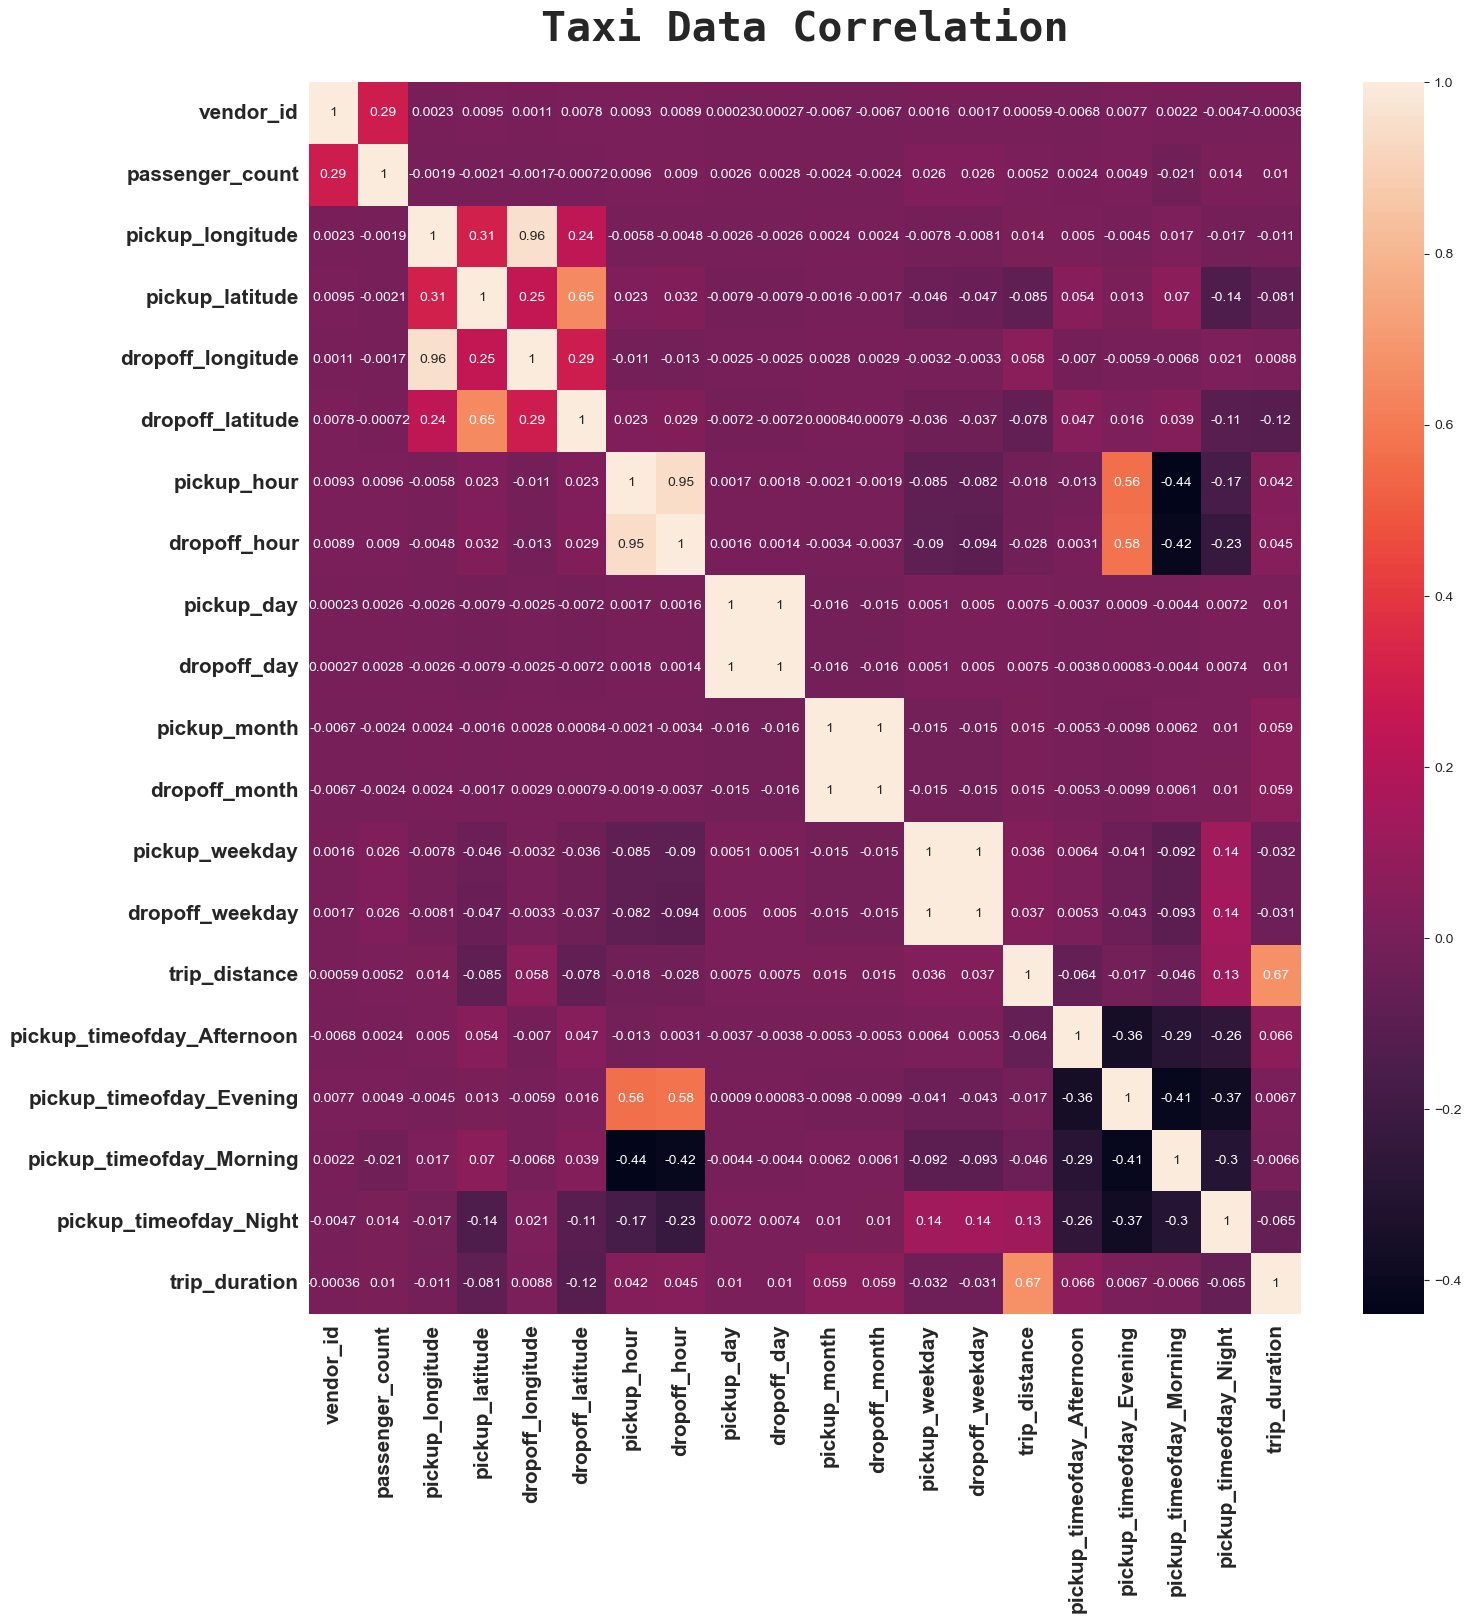

In [39]:
# Compute the correlation matrix
corr_matrix = numeric_df.corr()

sns.set_style("whitegrid") # set the seaborn style
plt.figure(figsize=(16, 16)) # figure the size
sns.heatmap(corr_matrix, annot=True,) # create a heatmap
plt.title("Taxi Data Correlation", weight="bold", fontsize=30, fontname="monospace", pad=30) # title
plt.xticks(weight="bold", fontsize=15) # x-ticks
plt.yticks(weight="bold", fontsize=15); # y-ticks


In [40]:
X_train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,dropoff_hour,dropoff_timeofday,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,calc_trip_duration,trip_distance,pickup_timeofday_Afternoon,pickup_timeofday_Evening,pickup_timeofday_Morning,pickup_timeofday_Night
879655,id2425795,1,2016-01-08 23:55:11,2016-01-09 00:04:32,1,-73.955551,40.773346,-73.973640,40.763500,N,561,23,0,Night,8,9,1,1,4,5,561.0,1.875964,0,0,0,1
646838,id0767831,2,2016-03-05 09:52:06,2016-03-05 10:00:12,1,-73.962181,40.763599,-73.980377,40.764919,N,486,9,10,Morning,5,5,3,3,5,5,486.0,1.539475,0,0,1,0
1138713,id0449104,1,2016-04-09 16:03:53,2016-04-09 16:21:22,1,-73.977486,40.751842,-74.011688,40.718925,N,1049,16,16,Evening,9,9,4,4,5,5,1049.0,4.658508,0,1,0,0
864716,id3030157,1,2016-01-06 11:12:44,2016-01-06 11:19:49,1,-73.970001,40.762363,-73.963264,40.774666,N,425,11,11,Morning,6,6,1,1,2,2,425.0,1.480942,0,0,1,0
434927,id1584885,1,2016-06-26 09:10:56,2016-06-26 09:17:44,1,-73.950348,40.771561,-73.968178,40.762409,N,408,9,9,Morning,26,26,6,6,6,6,408.0,1.813886,0,0,1,0


### Selecting final features

In [41]:
drop_features = ['trip_duration','id','vendor_id','pickup_datetime','dropoff_datetime','store_and_fwd_flag','calc_trip_duration','dropoff_hour','dropoff_timeofday','dropoff_day','dropoff_month','dropoff_weekday', 'pickup_day', 'pickup_timeofday_Evening', 'pickup_timeofday_Morning','pickup_timeofday_Night']

x_train = X_train_df.drop(drop_features,axis=1)
y_train = X_train_df['trip_duration']


x_train.head()


,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,pickup_month,pickup_weekday,trip_distance,pickup_timeofday_Afternoon
879655,1,-73.955551,40.773346,-73.973640,40.763500,23,1,4,1.875964,0
646838,1,-73.962181,40.763599,-73.980377,40.764919,9,3,5,1.539475,0
1138713,1,-73.977486,40.751842,-74.011688,40.718925,16,4,5,4.658508,0
864716,1,-73.970001,40.762363,-73.963264,40.774666,11,1,2,1.480942,0
434927,1,-73.950348,40.771561,-73.968178,40.762409,9,6,6,1.813886,0


In [42]:
print(x_train.shape)

print(y_train.shape)


(1173246, 10)
(1173246,)


## Cleaning Test Set

In [43]:
print(X_test.shape)

X_test_pd = pd.DataFrame(X_test)

X_test_pd.head()

(145865, 10)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
67250,id2793718,2,2016-06-08 07:36:19,2016-06-08 07:53:39,1,-73.985611,40.735943,-73.980331,40.760468,N
1397036,id3485529,2,2016-04-03 12:58:11,2016-04-03 13:11:58,1,-73.978394,40.764351,-73.991623,40.749859,N
1021087,id1816614,2,2016-06-05 02:49:13,2016-06-05 02:59:27,5,-73.989059,40.744389,-73.973381,40.748692,N
951424,id1050851,2,2016-05-05 17:18:27,2016-05-05 17:32:54,2,-73.990326,40.731136,-73.991264,40.748917,N
707882,id0140657,1,2016-05-12 17:43:38,2016-05-12 19:06:25,4,-73.789497,40.646675,-73.987137,40.759232,N


In [44]:
print(y_test.shape)
y_test_pd = pd.DataFrame(y_test)

y_test_pd.head(10)

(145865,)


,trip_duration
67250,1040
1397036,827
1021087,614
951424,867
707882,4967
1432685,374
528407,1252
1217989,148
1165122,1499
1324437,1017


### Concatenate x-test and y-test

In [45]:

y_new_pd = pd.concat([X_test_pd,y_test_pd],axis =1)

y_new_pd.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
67250,id2793718,2,2016-06-08 07:36:19,2016-06-08 07:53:39,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1397036,id3485529,2,2016-04-03 12:58:11,2016-04-03 13:11:58,1,-73.978394,40.764351,-73.991623,40.749859,N,827
1021087,id1816614,2,2016-06-05 02:49:13,2016-06-05 02:59:27,5,-73.989059,40.744389,-73.973381,40.748692,N,614
951424,id1050851,2,2016-05-05 17:18:27,2016-05-05 17:32:54,2,-73.990326,40.731136,-73.991264,40.748917,N,867
707882,id0140657,1,2016-05-12 17:43:38,2016-05-12 19:06:25,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


### Check for null

In [46]:
y_new_pd.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Pre-processing Test Set

In [47]:
preprocess_test = pre_process_features(y_new_pd)
pd.set_option('display.max_columns', None)
preprocess_test.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,dropoff_hour,pickup_timeofday,dropoff_timeofday,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,calc_trip_duration,trip_distance
67250,id2793718,2,2016-06-08 07:36:19,2016-06-08 07:53:39,1,-73.985611,40.735943,-73.980331,40.760468,N,1040,7,7,Morning,Morning,8,8,6,6,2,2,1040.0,2.763050
1397036,id3485529,2,2016-04-03 12:58:11,2016-04-03 13:11:58,1,-73.978394,40.764351,-73.991623,40.749859,N,827,12,13,Afternoon,Afternoon,3,3,4,4,6,6,827.0,1.959178
1021087,id1816614,2,2016-06-05 02:49:13,2016-06-05 02:59:27,5,-73.989059,40.744389,-73.973381,40.748692,N,614,2,2,Night,Night,5,5,6,6,6,6,614.0,1.404772
951424,id1050851,2,2016-05-05 17:18:27,2016-05-05 17:32:54,2,-73.990326,40.731136,-73.991264,40.748917,N,867,17,17,Evening,Evening,5,5,5,5,3,3,867.0,1.978660
707882,id0140657,1,2016-05-12 17:43:38,2016-05-12 19:06:25,4,-73.789497,40.646675,-73.987137,40.759232,N,4967,17,19,Evening,Evening,12,12,5,5,3,3,4967.0,20.837745


In [48]:
X_test_df = preprocess_test.copy()

In [49]:
X_test_df.shape

(145865, 23)

## Exploriing Test Set

In [50]:
X_test_df['passenger_count'].value_counts()

passenger_count
1    103132
2     21115
5      7831
3      6047
6      4866
4      2868
0         6
Name: count, dtype: int64

In [51]:
# Remove outliers

X_test_df = X_test_df[(X_test_df['passenger_count'] != 0) & (X_test_df['passenger_count'] <= 6)]

X_test_df['passenger_count'].value_counts()

passenger_count
1    103132
2     21115
5      7831
3      6047
6      4866
4      2868
Name: count, dtype: int64

In [52]:
X_test_df['trip_duration'].value_counts()

trip_duration
563     182
363     178
348     178
370     177
368     176
       ... 
4948      1
4003      1
4604      1
3136      1
3719      1
Name: count, Length: 4474, dtype: int64

In [53]:
X_test_df = X_test_df[X_test_df['trip_distance'] != X_test_df['trip_distance'].min()]

max_trip_hr = X_test_df['trip_duration'].max() / 3600

print("Max: ", max_trip_hr)

Max:  23.990555555555556


In [54]:
# Calculate the first (Q1) and third quartile (Q3) of 'trip_distance'
Q1 = X_test_df['trip_distance'].quantile(0.25)
Q3 = X_test_df['trip_distance'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of data points greater than upper_bound
greater_than_upper = X_test_df[X_test_df['trip_distance'] > upper_bound].shape[0]

# Count the number of data points lower than lower_bound
lower_than_lower = X_test_df[X_test_df['trip_distance'] < lower_bound].shape[0]

# Print the results
print(f"Number of data points greater than the upper bound: {greater_than_upper}")
print(f"Number of data points lower than the lower bound: {lower_than_lower}")



Number of data points greater than the upper bound: 13972
Number of data points lower than the lower bound: 0


In [55]:
#Removing outliers for trip distance
X_test_df = X_test_df[(X_test_df['trip_distance'] >= lower_bound) & (X_test_df['trip_distance'] <= upper_bound)]

print(X_test_df.shape)

(131272, 23)


In [56]:
X_test_df['trip_duration'].sort_values(ascending= False)

483960     86366
1282413    86365
755015     86362
88508      86358
1437604    86357
           ...  
303791         2
730299         2
1075427        2
1020268        2
311745         1
Name: trip_duration, Length: 131272, dtype: int64

In [57]:
X_test_df= X_test_df[X_test_df.trip_duration <= 5000]
X_test_df = X_test_df[X_test_df.trip_duration >= 60]

In [58]:
X_test_df['trip_duration'].value_counts()

trip_duration
563     182
370     177
368     176
378     175
363     175
       ... 
2794      1
2355      1
3201      1
2695      1
2975      1
Name: count, Length: 2825, dtype: int64

### Final Test Features

In [59]:
X_test_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,dropoff_hour,pickup_timeofday,dropoff_timeofday,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,calc_trip_duration,trip_distance
67250,id2793718,2,2016-06-08 07:36:19,2016-06-08 07:53:39,1,-73.985611,40.735943,-73.980331,40.760468,N,1040,7,7,Morning,Morning,8,8,6,6,2,2,1040.0,2.763050
1397036,id3485529,2,2016-04-03 12:58:11,2016-04-03 13:11:58,1,-73.978394,40.764351,-73.991623,40.749859,N,827,12,13,Afternoon,Afternoon,3,3,4,4,6,6,827.0,1.959178
1021087,id1816614,2,2016-06-05 02:49:13,2016-06-05 02:59:27,5,-73.989059,40.744389,-73.973381,40.748692,N,614,2,2,Night,Night,5,5,6,6,6,6,614.0,1.404772
951424,id1050851,2,2016-05-05 17:18:27,2016-05-05 17:32:54,2,-73.990326,40.731136,-73.991264,40.748917,N,867,17,17,Evening,Evening,5,5,5,5,3,3,867.0,1.978660
1432685,id2734699,2,2016-04-14 12:17:42,2016-04-14 12:23:56,3,-73.969833,40.768570,-73.962646,40.767181,N,374,12,12,Afternoon,Afternoon,14,14,4,4,3,3,374.0,0.624626


In [60]:
X_test_df = X_test_df.join(pd.get_dummies(X_test_df['pickup_timeofday'], prefix='pickup_timeofday', dtype=int))


In [61]:
X_test_df.drop(columns=['pickup_timeofday'], inplace=True)
X_test_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,dropoff_hour,dropoff_timeofday,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,calc_trip_duration,trip_distance,pickup_timeofday_Afternoon,pickup_timeofday_Evening,pickup_timeofday_Morning,pickup_timeofday_Night
67250,id2793718,2,2016-06-08 07:36:19,2016-06-08 07:53:39,1,-73.985611,40.735943,-73.980331,40.760468,N,1040,7,7,Morning,8,8,6,6,2,2,1040.0,2.763050,0,0,1,0
1397036,id3485529,2,2016-04-03 12:58:11,2016-04-03 13:11:58,1,-73.978394,40.764351,-73.991623,40.749859,N,827,12,13,Afternoon,3,3,4,4,6,6,827.0,1.959178,1,0,0,0
1021087,id1816614,2,2016-06-05 02:49:13,2016-06-05 02:59:27,5,-73.989059,40.744389,-73.973381,40.748692,N,614,2,2,Night,5,5,6,6,6,6,614.0,1.404772,0,0,0,1
951424,id1050851,2,2016-05-05 17:18:27,2016-05-05 17:32:54,2,-73.990326,40.731136,-73.991264,40.748917,N,867,17,17,Evening,5,5,5,5,3,3,867.0,1.978660,0,1,0,0
1432685,id2734699,2,2016-04-14 12:17:42,2016-04-14 12:23:56,3,-73.969833,40.768570,-73.962646,40.767181,N,374,12,12,Afternoon,14,14,4,4,3,3,374.0,0.624626,1,0,0,0


In [62]:
drop_features_test = ['trip_duration','id','vendor_id','pickup_datetime','dropoff_datetime','store_and_fwd_flag','calc_trip_duration','dropoff_hour','dropoff_timeofday','dropoff_day','dropoff_month','dropoff_weekday', 'pickup_day', 'pickup_timeofday_Evening', 'pickup_timeofday_Morning','pickup_timeofday_Night']


x_test = X_test_df.drop(drop_features_test,axis=1)
y_test = X_test_df['trip_duration']

In [63]:
x_test.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,pickup_month,pickup_weekday,trip_distance,pickup_timeofday_Afternoon
67250,1,-73.985611,40.735943,-73.980331,40.760468,7,6,2,2.763050,0
1397036,1,-73.978394,40.764351,-73.991623,40.749859,12,4,6,1.959178,1
1021087,5,-73.989059,40.744389,-73.973381,40.748692,2,6,6,1.404772,0
951424,2,-73.990326,40.731136,-73.991264,40.748917,17,5,3,1.978660,0
1432685,3,-73.969833,40.768570,-73.962646,40.767181,12,4,3,0.624626,1


## Trip Duration Prediction

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error

### Normalize features

In [65]:

def normalize_features(df, scaler =None, fit_scaler=True):
    
    #df = pd.get_dummies(df, columns=['pickup_timeofday'], drop_first=True)
    
    numerical_columns = df.select_dtypes(include=['number']).columns
    
    if fit_scaler:
        scaler = StandardScaler()
        df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    else:
        df[numerical_columns] = scaler.transform(df[numerical_columns])
    
    return df.to_numpy(), scaler

### Pre-process Features

In [66]:
x_train_processed, scaler = normalize_features(x_train, fit_scaler=True)
x_test_processed, _ = normalize_features(x_test, scaler=scaler, fit_scaler=False)

In [112]:
x_train_processed

array([[-0.50356173,  0.36612443,  0.85188469, ...,  0.48585591,
        -0.31791703, -0.49836777],
       [-0.50356173,  0.26595729,  0.44486321, ...,  0.99898414,
        -0.52357692, -0.49836777],
       [-0.50356173,  0.03473143, -0.04611142, ...,  0.99898414,
         1.38275713, -0.49836777],
       ...,
       [-0.50356173,  0.09317187,  0.45824474, ..., -1.05352878,
        -0.37426103, -0.49836777],
       [-0.50356173, -0.39901877, -0.77938729, ..., -1.05352878,
         3.06301389, -0.49836777],
       [-0.50356173,  0.26353668,  0.60034382, ..., -1.05352878,
        -1.07197689, -0.49836777]])

### Convert to numpy

In [67]:
x_test_processed.shape

(130336, 10)

In [68]:
y_test = y_test.to_numpy()

In [101]:
y_test = y_test.reshape(-1,1)
y_test

array([[1040],
       [ 827],
       [ 614],
       ...,
       [ 779],
       [ 393],
       [ 764]], dtype=int64)

In [69]:
y_train = y_train.to_numpy()

### Train Test Split

In [70]:
train_x, val_x, train_y, val_y = train_test_split(x_train_processed, y_train, test_size=0.2, random_state=42)


### Shape changes

In [71]:
train_y = train_y.reshape(-1,1)


In [72]:

print(train_y.shape)

(938596, 1)


In [73]:
val_y.shape

(234650,)

In [74]:
val_y = val_y.reshape(-1,1)

In [75]:
val_y.shape

(234650, 1)

### Model 1 for Prediciton

In [76]:
input_features = train_x.shape[1]
input_features

10

#### Creating Model

In [77]:
model_taxi_1 = Sequential()
model_taxi_1.add(Linear(input_features, 64))
model_taxi_1.add(ReLU())
model_taxi_1.add(Linear(64,32))
model_taxi_1.add(ReLU())
model_taxi_1.add(Linear(32,1))

print(model_taxi_1)


Sequential Model:
Layer 1: Linear
  Weights: (64, 10)
  Bias: (64,)
Layer 2: ReLU
Layer 3: Linear
  Weights: (32, 64)
  Bias: (32,)
Layer 4: ReLU
Layer 5: Linear
  Weights: (1, 32)
  Bias: (1,)



#### Loss functions

In [78]:
def msle(y_true, y_pred):
    diff = np.log1p(y_true) - np.log1p(y_pred)
    return np.mean(diff ** 2)

def msle_gradient(y_true, y_pred):
    n = len(y_true)
    grad = 2 * (np.log1p(y_pred) - np.log1p(y_true)) / (1 + y_pred) / n
    return grad

#### Train Model

In [79]:


def train_model(model, x_train, y_train, x_val, y_val, epochs=100, batch_size=64, learning_rate=0.01, patience=3):
    num_samples = x_train.shape[0]
    
    best_loss = float('inf')
    p_count = 0
    epoch_loss = 0
    num_batches = 0
    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        rand_idxs = np.random.permutation(len(x_train))
        x_train = x_train[rand_idxs]
        y_train = y_train[rand_idxs]
        
        for i in range(0, num_samples, batch_size):
            end_idx = min(i+batch_size, num_samples)
            
            batch_x = x_train[i:end_idx]
            batch_y = y_train[i:end_idx].reshape(-1,1)
            
            # forwards pass
            y_pred = model.forward(batch_x)
            
            # loss
            msle_loss = msle(batch_y,y_pred)
            
            epoch_loss += msle_loss
            num_batches+=1
            
            
            gradients = msle_gradient(batch_y, y_pred)

            # backprop
            model.backward(gradients)
            
            # params update
            for layer in model.layers:
                if hasattr(layer, 'weights'):
                    layer.weights -= learning_rate * layer.grad_weights
                    layer.bias -= learning_rate * layer.grad_bias
        
        # Epoch loss by batch            
        avg_train_loss = epoch_loss /num_batches
        train_loss_history.append(avg_train_loss)
        
        val_pred = model.forward(x_val)
   
        
        
        val_loss = msle(y_val,val_pred)
        
        val_loss_history.append(val_loss)    
            

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.5f}, Val Loss: {val_loss:.5f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            p_count = 0
        else:
            p_count += 1

        if p_count >= patience:
            print(f"Early stopping at epoch {epoch+1}.")
            break
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


In [80]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((938596, 10), (938596, 1), (234650, 10), (234650, 1))

## Results

### Model 1

Epoch [10/100], Loss: 18267.52943, Val Loss: 0.19326
Epoch [20/100], Loss: 32341.54260, Val Loss: 0.19116
Epoch [30/100], Loss: 46274.35215, Val Loss: 0.18883
Epoch [40/100], Loss: 59975.32680, Val Loss: 0.18475
Epoch [50/100], Loss: 73333.42044, Val Loss: 0.17975
Epoch [60/100], Loss: 86362.49313, Val Loss: 0.17584
Epoch [70/100], Loss: 99132.29926, Val Loss: 0.17245
Epoch [80/100], Loss: 111654.44218, Val Loss: 0.16912
Epoch [90/100], Loss: 123940.24131, Val Loss: 0.16605
Epoch [100/100], Loss: 136013.61825, Val Loss: 0.16343


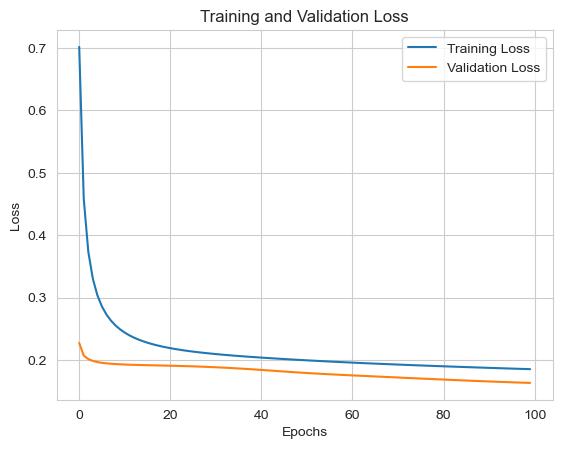

In [81]:
train_model(model_taxi_1, train_x, train_y, val_x, val_y, epochs=100, batch_size=128, learning_rate=0.01, patience=3)

In [97]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.forward(X_test)  # Get predictions
    rsmle_loss = mean_squared_log_error(y_test,y_pred)  # Compute MSLE
    print(f"Test MSLE: {rsmle_loss:.4f}")
    return rsmle_loss

In [102]:
rsmle_model_1 = evaluate_model(model_taxi_1, x_test_processed,y_test)


Test MSLE: 0.1647


### Model 2

In [113]:
model_taxi_2 = Sequential()
model_taxi_2.add(Linear(input_features, 128))
model_taxi_2.add(ReLU())
model_taxi_2.add(Linear(128, 64))
model_taxi_2.add(ReLU())
model_taxi_2.add(Linear(64, 32))
model_taxi_2.add(ReLU())
model_taxi_2.add(Linear(32, 1))

Epoch [10/50], Loss: 23042.89023, Val Loss: 0.13297
Epoch [20/50], Loss: 41365.29530, Val Loss: 0.12608
Epoch [30/50], Loss: 58850.95567, Val Loss: 0.11967
Early stopping at epoch 34.


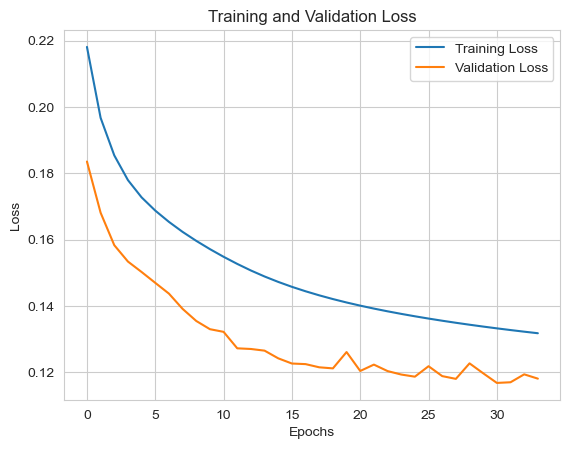

In [114]:
train_model(model_taxi_2, train_x, train_y, val_x, val_y, epochs=50, batch_size=64, learning_rate=0.05, patience=3)

In [116]:
rsmle_model_2 = evaluate_model(model_taxi_2, x_test_processed,y_test)


Test MSLE: 0.1192


### Model 3

In [117]:
model_taxi_3 = Sequential()
model_taxi_3.add(Linear(input_features, 256))
model_taxi_3.add(ReLU())
model_taxi_3.add(Linear(256, 128))
model_taxi_3.add(ReLU())
model_taxi_3.add(Linear(128, 64))
model_taxi_3.add(ReLU())
model_taxi_3.add(Linear(64, 32))
model_taxi_3.add(ReLU())
model_taxi_3.add(Linear(32, 1))


Epoch [10/50], Loss: 40761.09516, Val Loss: 0.19550
Epoch [20/50], Loss: 68490.78495, Val Loss: 0.18360
Epoch [30/50], Loss: 94658.55552, Val Loss: 0.17354
Epoch [40/50], Loss: 119481.25899, Val Loss: 0.16554
Epoch [50/50], Loss: 143317.06320, Val Loss: 0.16016


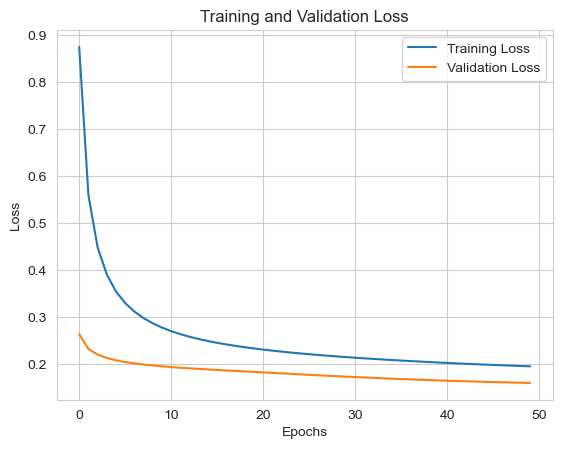

In [118]:
train_model(model_taxi_3, train_x, train_y, val_x, val_y, epochs=50, batch_size=64, learning_rate=0.001, patience=3)

In [119]:
rsmle_model_3 = evaluate_model(model_taxi_3, x_test_processed,y_test)


Test MSLE: 0.1615


## Comparisons

Based on the 3 configurations, Model 2 performed better.